# Pet Segmentation using U-Net

This notebook trains a U-Net model for pet segmentation using our augmented dataset with proper train/val/test splits.

## 1. Setup and Import Libraries

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
from scipy.ndimage import gaussian_filter, map_coordinates
import time

# Get the absolute path to the project root directory (parent of both notebooks and src)
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.append(project_root)

# Then import the module directly
from src.data_preprocessing import PetDataset

# Set random seed for reproducibility
torch.manual_seed(100)
if torch.cuda.is_available():
    torch.cuda.manual_seed(100)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check GPU memory if available
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Available GPU memory: {torch.cuda.mem_get_info()[0] / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Ti
Total GPU memory: 17.18 GB
Available GPU memory: 15.96 GB


## 3. Create Data Loaders

In [2]:
# Set paths and create datasets
data_root = '../Dataset_augmented/'

# Create datasets - directly use train/val/test splits from the augmented dataset
train_dataset = PetDataset(data_root, 'train')
val_dataset = PetDataset(data_root, 'val')
test_dataset = PetDataset(data_root, 'test')

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

print(f"Checking dataset contents...")
train_dir = os.path.join(data_root, 'train', 'color')
print(f"Train image count: {len(os.listdir(train_dir))}")
print(f"Checking first few images...")
for i, f in enumerate(os.listdir(train_dir)[:5]):
    path = os.path.join(train_dir, f)
    size = os.path.getsize(path) / (1024*1024)  # Size in MB
    print(f"  {f}: {size:.2f} MB")

# Create dataloaders
batch_size = 64
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

Training set size: 11776
Validation set size: 736
Test set size: 3710
Checking dataset contents...
Train image count: 11776
Checking first few images...
  Maine_Coon_133.jpg: 0.19 MB
  Maine_Coon_133_aug0.jpg: 0.01 MB
  Maine_Coon_133_aug1.jpg: 0.01 MB
  Maine_Coon_133_aug2.jpg: 0.01 MB
  Siamese_200.jpg: 0.08 MB


## 4. U-Net Model Definition

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [4]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features_start=32):
        super(UNet, self).__init__()
        
        # Starting with 224x224 input
        # After 4 max pools of stride 2: 224 -> 112 -> 56 -> 28 -> 14
        
        # Encoder (Downsampling)
        self.encoder1 = DoubleConv(in_channels, features_start)  # 224 -> 224
        self.pool1 = nn.MaxPool2d(2)  # 224 -> 112
        self.encoder2 = DoubleConv(features_start, features_start*2)  # 112 -> 112
        self.pool2 = nn.MaxPool2d(2)  # 112 -> 56
        self.encoder3 = DoubleConv(features_start*2, features_start*4)  # 56 -> 56
        self.pool3 = nn.MaxPool2d(2)  # 56 -> 28
        self.encoder4 = DoubleConv(features_start*4, features_start*8)  # 28 -> 28
        self.pool4 = nn.MaxPool2d(2)  # 28 -> 14
        
        # Bottom
        self.bottom = DoubleConv(features_start*8, features_start*16)  # 14 -> 14
        
        # Decoder (Upsampling)
        self.upconv4 = nn.ConvTranspose2d(features_start*16, features_start*8, kernel_size=2, stride=2)  # 14 -> 28
        self.decoder4 = DoubleConv(features_start*16, features_start*8)  # 28 -> 28
        self.upconv3 = nn.ConvTranspose2d(features_start*8, features_start*4, kernel_size=2, stride=2)  # 28 -> 56
        self.decoder3 = DoubleConv(features_start*8, features_start*4)  # 56 -> 56
        self.upconv2 = nn.ConvTranspose2d(features_start*4, features_start*2, kernel_size=2, stride=2)  # 56 -> 112
        self.decoder2 = DoubleConv(features_start*4, features_start*2)  # 112 -> 112
        self.upconv1 = nn.ConvTranspose2d(features_start*2, features_start, kernel_size=2, stride=2)  # 112 -> 224
        self.decoder1 = DoubleConv(features_start*2, features_start)  # 224 -> 224
        
        # Final Convolution
        self.final_conv = nn.Conv2d(features_start, out_channels, kernel_size=1)  # 224 -> 224

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)  # 224
        enc2 = self.encoder2(self.pool1(enc1))  # 112
        enc3 = self.encoder3(self.pool2(enc2))  # 56
        enc4 = self.encoder4(self.pool3(enc3))  # 28
        
        # Bottom
        bottom = self.bottom(self.pool4(enc4))  # 14
        
        # Decoder with skip connections
        dec4 = self.upconv4(bottom)  # 28
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)  # 56
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)  # 112
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)  # 224
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.decoder1(dec1)
        
        return self.final_conv(dec1)

## 5. Training and Evaluation Functions

In [5]:
def train_unet(model, train_loader, val_loader, num_epochs=50, cat_weight=1, device=device):
    """
    Train the U-Net model.
    
    Args:
        model: U-Net model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Number of epochs to train
        cat_weight: Weight for the cat class
        device: Device to train on
        
    Returns:
        Trained model
    """

    # Add these lines at the beginning
    from torch.cuda.amp import autocast, GradScaler
    scaler = GradScaler()
    accumulation_steps = 2
    
    print("Function started: train_unet")
    start_time = time.time()
    
    # Define class weights to address class imbalance [background, cat, dog]
    print("Setting up class weights...")
    class_weights = torch.tensor([1.0, cat_weight, 1.0], device=device)
    print(f"Class weights created: {time.time() - start_time:.2f}s")

    # Define loss function with class weights and ignore_index for white pixels
    print("Setting up criterion...")
    criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=255)
    print(f"Criterion created: {time.time() - start_time:.2f}s")
    
    # Define optimizer
    print("Setting up optimizer...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f"Optimizer created: {time.time() - start_time:.2f}s")
    
    # Test data loading
    print("Testing data loading...")
    try:
        test_imgs, test_masks = next(iter(train_loader))
        print(f"Sample batch loaded - images: {test_imgs.shape}, masks: {test_masks.shape}")
        print(f"Data loading test: {time.time() - start_time:.2f}s")
        
        # Test batch to GPU transfer
        print("Testing batch GPU transfer...")
        test_imgs = test_imgs.to(device)
        test_masks = test_masks.to(device)
        print(f"GPU transfer test: {time.time() - start_time:.2f}s")
        
        # Test forward pass
        print("Testing forward pass...")
        with torch.no_grad():
            test_output = model(test_imgs)
        print(f"Forward pass test: {time.time() - start_time:.2f}s")
    except Exception as e:
        print(f"Error in data loading test: {e}")
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Track best model
    best_val_loss = float('inf')
    best_model = None
    
    # Training history
    train_losses = []
    val_losses = []
    train_iou = []
    val_iou = []
    train_dice = []
    val_dice = []
    prev_lr = optimizer.param_groups[0]['lr']
    
    # Create figures for live plotting
    plt.ion()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # GPU memory tracking
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
            mem_allocated_start = torch.cuda.memory_allocated() / 1e9
        
        # Training phase
        model.train()
        running_loss = 0.0
        intersection = torch.zeros(3, device=device)
        union = torch.zeros(3, device=device)
        dice_intersection = torch.zeros(3, device=device)
        dice_sum = torch.zeros(3, device=device)
        
        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)", leave=True)
        
        # Reset gradients at the start of each epoch
        optimizer.zero_grad()
        batch_count = 0
        
        for images, masks in train_pbar:
            batch_count += 1
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass with mixed precision
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
            
            # Scale loss by accumulation steps and backward pass
            loss = loss / accumulation_steps
            scaler.scale(loss).backward()
            
            # Update weights after accumulation_steps
            if batch_count % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            # Track loss (use the original loss value for tracking)
            running_loss += (loss.item() * accumulation_steps) * images.size(0)
            
            # Calculate metrics (use non-scaled outputs)
            with torch.no_grad():
                _, predicted = torch.max(outputs, 1)
                mask = (masks != 255)
                
                # Calculate IoU and Dice metrics
                for cls in range(3):
                    pred_cls = (predicted == cls) & mask
                    true_cls = (masks == cls) & mask
                    
                    intersection[cls] += (pred_cls & true_cls).sum().float()
                    union[cls] += (pred_cls | true_cls).sum().float()
                    
                    dice_intersection[cls] += (pred_cls & true_cls).sum().float()
                    dice_sum[cls] += pred_cls.sum().float() + true_cls.sum().float()
            
            # Update progress bar
            train_pbar.set_postfix(loss=loss.item() * accumulation_steps)
        
        # Make sure to update for any remaining batches (if dataset size % accumulation_steps != 0)
        if batch_count % accumulation_steps != 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Calculate average training metrics
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Calculate IoU
        class_ious = []
        for cls in range(3):
            iou = intersection[cls] / union[cls] if union[cls] > 0 else 0
            class_ious.append(iou.item())
        mean_iou = sum(class_ious) / len(class_ious)
        train_iou.append(mean_iou)
        
        # Calculate Dice coefficient
        class_dice = []
        for cls in range(3):
            dice = (2 * dice_intersection[cls]) / dice_sum[cls] if dice_sum[cls] > 0 else 0
            class_dice.append(dice.item())
        mean_dice = sum(class_dice) / len(class_dice)
        train_dice.append(mean_dice)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_intersection = torch.zeros(3, device=device)
        val_union = torch.zeros(3, device=device)
        val_dice_intersection = torch.zeros(3, device=device)
        val_dice_sum = torch.zeros(3, device=device)
        
        # Progress bar for validation
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)", leave=False)
        
        with torch.no_grad():
            for images, masks in val_pbar:
                # Move data to device
                images = images.to(device)
                masks = masks.to(device)
                
                # Forward pass
                outputs = model(images)
                
                # Calculate loss
                loss = criterion(outputs, masks)
                
                # Track loss
                val_running_loss += loss.item() * images.size(0)
                
                # Calculate metrics
                _, predicted = torch.max(outputs, 1)
                mask = (masks != 255)
                
                # Calculate IoU
                for cls in range(3):  # 3 classes: background, cat, dog
                    pred_cls = (predicted == cls) & mask
                    true_cls = (masks == cls) & mask
                    
                    # Intersection and union
                    val_intersection[cls] += (pred_cls & true_cls).sum().float()
                    val_union[cls] += (pred_cls | true_cls).sum().float()
                    
                    # Dice coefficient
                    val_dice_intersection[cls] += (pred_cls & true_cls).sum().float()
                    val_dice_sum[cls] += pred_cls.sum().float() + true_cls.sum().float()
                
                # Update progress bar
                val_pbar.set_postfix(loss=loss.item())
        
        # Calculate average validation metrics
        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Calculate IoU
        val_class_ious = []
        for cls in range(3):
            iou = val_intersection[cls] / val_union[cls] if val_union[cls] > 0 else 0
            val_class_ious.append(iou.item())
        val_mean_iou = sum(val_class_ious) / len(val_class_ious)
        val_iou.append(val_mean_iou)
        
        # Calculate Dice coefficient
        val_class_dice = []
        for cls in range(3):
            dice = (2 * val_dice_intersection[cls]) / val_dice_sum[cls] if val_dice_sum[cls] > 0 else 0
            val_class_dice.append(dice.item())
        val_mean_dice = sum(val_class_dice) / len(val_class_dice)
        val_dice.append(val_mean_dice)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Check for learning rate changes
        current_lr = optimizer.param_groups[0]['lr']
        lr_changed = current_lr != prev_lr
        
        # GPU memory usage
        gpu_info = ""
        if torch.cuda.is_available():
            mem_allocated_peak = torch.cuda.max_memory_allocated() / 1e9
            mem_allocated_end = torch.cuda.memory_allocated() / 1e9
            gpu_info = f", Peak GPU Memory: {mem_allocated_peak:.2f} GB"
        
        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        
        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}] - {epoch_time:.1f}s{gpu_info}")
        print(f"  Train: Loss={train_loss:.4f}, IoU={mean_iou:.4f}, Dice={mean_dice:.4f}")
        print(f"  Val: Loss={val_loss:.4f}, IoU={val_mean_iou:.4f}, Dice={val_mean_dice:.4f}")
        
        if lr_changed:
            print(f"  Learning rate changed from {prev_lr:.6f} to {current_lr:.6f}")
            prev_lr = current_lr
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
            print(f"  New best model saved with validation loss: {val_loss:.4f}")
            
            # Save checkpoint
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_iou': mean_iou,
                'val_iou': val_mean_iou,
                'train_dice': mean_dice,
                'val_dice': val_mean_dice
            }, 'unet_pet_segmentation_best.pt')
    
        
        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_iou': mean_iou,
                'val_iou': val_mean_iou,
                'train_dice': mean_dice,
                'val_dice': val_mean_dice
            }, f'unet_pet_segmentation_epoch_{epoch+1}.pt')
    
    
    # Load best model
    model.load_state_dict(best_model)
    
    # Save final model
    torch.save(model.state_dict(), 'unet_pet_segmentation_final.pth')
    
    # Create final plots
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'b-', label='Training Loss')
    plt.plot(val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_iou, 'b--', label='Train IoU')
    plt.plot(val_iou, 'r--', label='Val IoU')
    plt.plot(train_dice, 'b-', label='Train Dice')
    plt.plot(val_dice, 'r-', label='Val Dice')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('IoU and Dice Scores')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()
    
    return model, {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_iou': train_iou,
        'val_iou': val_iou,
        'train_dice': train_dice,
        'val_dice': val_dice
    }

In [6]:
def evaluate_unet(model, dataloader, device):
    """
    Evaluate the U-Net model.
    
    Args:
        model: U-Net model
        dataloader: DataLoader for evaluation data
        device: Device to evaluate on
        
    Returns:
        Dictionary of evaluation metrics
    """
    model.eval()
    
    # Initialize metrics
    correct = 0
    total = 0
    
    # Initialize IoU and Dice metrics - one for each class
    num_classes = 3  # background (0), cat (1), dog (2)
    intersection = torch.zeros(num_classes, device=device)
    union = torch.zeros(num_classes, device=device)
    dice_intersection = torch.zeros(num_classes, device=device)
    dice_sum = torch.zeros(num_classes, device=device)
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            # Get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Calculate accuracy (ignoring white pixels with value 255)
            mask = (masks != 255)
            correct += (predicted[mask] == masks[mask]).sum().item()
            total += mask.sum().item()
            
            # Calculate IoU and Dice for each class
            for cls in range(num_classes):
                pred_cls = (predicted == cls) & mask
                true_cls = (masks == cls) & mask
                
                # Intersection and union
                intersection[cls] += (pred_cls & true_cls).sum().float()
                union[cls] += (pred_cls | true_cls).sum().float()
                
                # Dice coefficient
                dice_intersection[cls] += (pred_cls & true_cls).sum().float()
                dice_sum[cls] += pred_cls.sum().float() + true_cls.sum().float()
    
    # Calculate metrics
    accuracy = correct / total if total > 0 else 0
    
    # Calculate IoU for each class
    class_names = ["background", "cat", "dog"]
    class_ious = []
    class_dice = []
    
    for cls in range(num_classes):
        iou = intersection[cls] / union[cls] if union[cls] > 0 else 0
        class_ious.append(iou.item())
        
        dice = (2 * dice_intersection[cls]) / dice_sum[cls] if dice_sum[cls] > 0 else 0
        class_dice.append(dice.item())
        
        print(f"Class '{class_names[cls]}': IoU={iou:.4f}, Dice={dice:.4f}")
    
    # Calculate mean IoU and Dice
    mean_iou = sum(class_ious) / len(class_ious)
    mean_dice = sum(class_dice) / len(class_dice)
    
    print(f"Pixel Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Dice: {mean_dice:.4f}")
    
    return {
        "pixel_accuracy": accuracy,
        "class_ious": {class_names[i]: class_ious[i] for i in range(num_classes)},
        "mean_iou": mean_iou,
        "class_dice": {class_names[i]: class_dice[i] for i in range(num_classes)},
        "mean_dice": mean_dice
    }

In [7]:
def visualize_unet_results(model, dataloader, device, num_samples=3):
    """
    Visualize the U-Net model predictions.
    
    Args:
        model: U-Net model
        dataloader: DataLoader for visualization data
        device: Device to visualize on
        num_samples: Number of samples to visualize
    """
    model.eval()
    
    # Get a batch of samples
    dataiter = iter(dataloader)
    images, masks = next(dataiter)
    
    # Make sure we don't visualize more than what's available
    num_samples = min(num_samples, images.size(0))
    
    # Class colors for visualization
    colors = torch.tensor([
        [0, 0, 0],      # Background (black)
        [128, 0, 0],    # Cat (red)
        [0, 128, 0]     # Dog (green)
    ], dtype=torch.uint8)
    
    with torch.no_grad():
        # Get predictions
        outputs = model(images[:num_samples].to(device))
        _, predicted = torch.max(outputs, 1)
        
        # Create visualization
        fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
        
        for i in range(num_samples):
            # Original image
            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
            axs[i, 0].imshow(img)
            axs[i, 0].set_title('Original Image')
            axs[i, 0].axis('off')
            
            # Ground truth mask
            mask = masks[i].cpu().numpy()
            mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
            for j in range(3):  # 3 classes
                mask_rgb[mask == j] = colors[j].numpy()
            # Make ignored regions white
            mask_rgb[mask == 255] = [255, 255, 255]
            
            axs[i, 1].imshow(mask_rgb)
            axs[i, 1].set_title('Ground Truth Mask')
            axs[i, 1].axis('off')
            
            # Predicted mask
            pred = predicted[i].cpu().numpy()
            pred_rgb = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
            for j in range(3):  # 3 classes
                pred_rgb[pred == j] = colors[j].numpy()
            
            # Also make ignored regions white in prediction visualization
            pred_rgb[mask == 255] = [255, 255, 255]
            axs[i, 2].imshow(pred_rgb)
            axs[i, 2].set_title('Predicted Mask')
            axs[i, 2].axis('off')
        
        plt.tight_layout()
        plt.show()

## 6. Create and Train U-Net Model

In [8]:
# Create U-Net model with 3 output channels (background, cat, dog)
unet = UNet(in_channels=3, out_channels=3).to(device)
print("U-Net model created:")
print(f"Total parameters: {sum(p.numel() for p in unet.parameters()):,}")

print("Testing model forward pass...")
with torch.no_grad():
    dummy_input = torch.randn(2, 3, 224, 224).to(device)
    _ = unet(dummy_input)
print("Model verified, starting training...")

U-Net model created:
Total parameters: 7,763,107
Testing model forward pass...
Model verified, starting training...


Training U-Net...
Function started: train_unet
Setting up class weights...
Class weights created: 0.00s
Setting up criterion...
Criterion created: 0.00s
Setting up optimizer...
Optimizer created: 0.00s
Testing data loading...


C:\Users\dcb_r\AppData\Local\Temp\ipykernel_60264\1077879479.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Sample batch loaded - images: torch.Size([64, 3, 224, 224]), masks: torch.Size([64, 224, 224])
Data loading test: 1.63s
Testing batch GPU transfer...
GPU transfer test: 1.68s
Testing forward pass...
Forward pass test: 2.00s


Epoch 1/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

C:\Users\dcb_r\AppData\Local\Temp\ipykernel_60264\1077879479.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1/50] - 376.4s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.6897, IoU=0.3856, Dice=0.4833
  Val: Loss=0.5681, IoU=0.4027, Dice=0.4907
  New best model saved with validation loss: 0.5681


Epoch 2/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 2/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2/50] - 96.0s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.5417, IoU=0.4440, Dice=0.5267
  Val: Loss=0.4437, IoU=0.4679, Dice=0.5415
  New best model saved with validation loss: 0.4437


Epoch 3/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 3/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3/50] - 96.0s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.4810, IoU=0.4798, Dice=0.5686
  Val: Loss=0.3978, IoU=0.5314, Dice=0.6472
  New best model saved with validation loss: 0.3978


Epoch 4/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 4/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4/50] - 95.9s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.4228, IoU=0.5801, Dice=0.7059
  Val: Loss=0.4051, IoU=0.5834, Dice=0.7140


Epoch 5/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 5/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5/50] - 95.3s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.3650, IoU=0.6532, Dice=0.7762
  Val: Loss=0.3172, IoU=0.6677, Dice=0.7864
  New best model saved with validation loss: 0.3172


Epoch 6/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 6/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6/50] - 96.0s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.3001, IoU=0.7218, Dice=0.8314
  Val: Loss=0.2756, IoU=0.7230, Dice=0.8319
  New best model saved with validation loss: 0.2756


Epoch 7/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 7/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7/50] - 95.5s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.2563, IoU=0.7627, Dice=0.8609
  Val: Loss=0.2397, IoU=0.7577, Dice=0.8569
  New best model saved with validation loss: 0.2397


Epoch 8/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 8/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [8/50] - 95.7s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.2213, IoU=0.7972, Dice=0.8843
  Val: Loss=0.2535, IoU=0.7621, Dice=0.8605


Epoch 9/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 9/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [9/50] - 95.9s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.1950, IoU=0.8222, Dice=0.9005
  Val: Loss=0.2285, IoU=0.7710, Dice=0.8659
  New best model saved with validation loss: 0.2285


Epoch 10/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 10/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10/50] - 95.8s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.1662, IoU=0.8496, Dice=0.9174
  Val: Loss=0.2507, IoU=0.7502, Dice=0.8506


Epoch 11/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 11/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11/50] - 95.6s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.1471, IoU=0.8682, Dice=0.9286
  Val: Loss=0.1989, IoU=0.8113, Dice=0.8931
  New best model saved with validation loss: 0.1989


Epoch 12/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 12/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12/50] - 95.9s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.1311, IoU=0.8828, Dice=0.9371
  Val: Loss=0.1849, IoU=0.8198, Dice=0.8982
  New best model saved with validation loss: 0.1849


Epoch 13/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 13/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13/50] - 96.0s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.1103, IoU=0.9023, Dice=0.9482
  Val: Loss=0.2453, IoU=0.7731, Dice=0.8673


Epoch 14/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 14/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14/50] - 95.0s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0920, IoU=0.9196, Dice=0.9579
  Val: Loss=0.1973, IoU=0.8272, Dice=0.9029


Epoch 15/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 15/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15/50] - 94.8s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0863, IoU=0.9247, Dice=0.9607
  Val: Loss=0.2516, IoU=0.7773, Dice=0.8704


Epoch 16/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 16/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16/50] - 96.0s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0727, IoU=0.9371, Dice=0.9674
  Val: Loss=0.2236, IoU=0.8145, Dice=0.8947


Epoch 17/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 17/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17/50] - 95.6s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0662, IoU=0.9428, Dice=0.9705
  Val: Loss=0.1956, IoU=0.8247, Dice=0.9015


Epoch 18/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 18/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18/50] - 95.5s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0538, IoU=0.9553, Dice=0.9771
  Val: Loss=0.1918, IoU=0.8338, Dice=0.9073
  Learning rate changed from 0.001000 to 0.000500


Epoch 19/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 19/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19/50] - 95.2s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0337, IoU=0.9739, Dice=0.9868
  Val: Loss=0.1845, IoU=0.8555, Dice=0.9206
  New best model saved with validation loss: 0.1845


Epoch 20/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 20/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20/50] - 95.9s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0261, IoU=0.9805, Dice=0.9901
  Val: Loss=0.1880, IoU=0.8559, Dice=0.9209


Epoch 21/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 21/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [21/50] - 96.1s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0221, IoU=0.9838, Dice=0.9918
  Val: Loss=0.1976, IoU=0.8527, Dice=0.9190


Epoch 22/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 22/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [22/50] - 94.9s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0200, IoU=0.9853, Dice=0.9926
  Val: Loss=0.2067, IoU=0.8541, Dice=0.9198


Epoch 23/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 23/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [23/50] - 95.4s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0191, IoU=0.9859, Dice=0.9929
  Val: Loss=0.2101, IoU=0.8556, Dice=0.9207


Epoch 24/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 24/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [24/50] - 95.5s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0180, IoU=0.9860, Dice=0.9930
  Val: Loss=0.2325, IoU=0.8478, Dice=0.9159


Epoch 25/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 25/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [25/50] - 95.5s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0183, IoU=0.9861, Dice=0.9930
  Val: Loss=0.2134, IoU=0.8559, Dice=0.9209
  Learning rate changed from 0.000500 to 0.000250


Epoch 26/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 26/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [26/50] - 95.7s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0121, IoU=0.9914, Dice=0.9957
  Val: Loss=0.2173, IoU=0.8610, Dice=0.9239


Epoch 27/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 27/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [27/50] - 95.3s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0107, IoU=0.9925, Dice=0.9963
  Val: Loss=0.2224, IoU=0.8590, Dice=0.9227


Epoch 28/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 28/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [28/50] - 95.6s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0101, IoU=0.9930, Dice=0.9965
  Val: Loss=0.2263, IoU=0.8584, Dice=0.9224


Epoch 29/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 29/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [29/50] - 94.9s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0095, IoU=0.9934, Dice=0.9967
  Val: Loss=0.2321, IoU=0.8541, Dice=0.9197


Epoch 30/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 30/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [30/50] - 95.4s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0085, IoU=0.9942, Dice=0.9971
  Val: Loss=0.2379, IoU=0.8597, Dice=0.9231


Epoch 31/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 31/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [31/50] - 95.7s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0080, IoU=0.9945, Dice=0.9973
  Val: Loss=0.2419, IoU=0.8568, Dice=0.9214
  Learning rate changed from 0.000250 to 0.000125


Epoch 32/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 32/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [32/50] - 95.5s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0072, IoU=0.9951, Dice=0.9975
  Val: Loss=0.2456, IoU=0.8582, Dice=0.9223


Epoch 33/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 33/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [33/50] - 95.4s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0067, IoU=0.9955, Dice=0.9977
  Val: Loss=0.2462, IoU=0.8567, Dice=0.9214


Epoch 34/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 34/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [34/50] - 94.9s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0065, IoU=0.9956, Dice=0.9978
  Val: Loss=0.2532, IoU=0.8567, Dice=0.9214


Epoch 35/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 35/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [35/50] - 95.7s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0062, IoU=0.9959, Dice=0.9979
  Val: Loss=0.2525, IoU=0.8581, Dice=0.9222


Epoch 36/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 36/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [36/50] - 95.9s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0059, IoU=0.9961, Dice=0.9980
  Val: Loss=0.2549, IoU=0.8572, Dice=0.9217


Epoch 37/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 37/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [37/50] - 95.6s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0061, IoU=0.9959, Dice=0.9979
  Val: Loss=0.2544, IoU=0.8560, Dice=0.9209
  Learning rate changed from 0.000125 to 0.000063


Epoch 38/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 38/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [38/50] - 95.4s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0055, IoU=0.9963, Dice=0.9982
  Val: Loss=0.2580, IoU=0.8574, Dice=0.9218


Epoch 39/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 39/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [39/50] - 95.6s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0054, IoU=0.9964, Dice=0.9982
  Val: Loss=0.2594, IoU=0.8583, Dice=0.9223


Epoch 40/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 40/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [40/50] - 95.8s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0051, IoU=0.9967, Dice=0.9983
  Val: Loss=0.2600, IoU=0.8579, Dice=0.9221


Epoch 41/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 41/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [41/50] - 95.4s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0049, IoU=0.9967, Dice=0.9984
  Val: Loss=0.2651, IoU=0.8570, Dice=0.9215


Epoch 42/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 42/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [42/50] - 95.3s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0048, IoU=0.9968, Dice=0.9984
  Val: Loss=0.2650, IoU=0.8576, Dice=0.9219


Epoch 43/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 43/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [43/50] - 95.4s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0047, IoU=0.9969, Dice=0.9984
  Val: Loss=0.2699, IoU=0.8571, Dice=0.9216
  Learning rate changed from 0.000063 to 0.000031


Epoch 44/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 44/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [44/50] - 95.2s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0046, IoU=0.9969, Dice=0.9985
  Val: Loss=0.2655, IoU=0.8564, Dice=0.9212


Epoch 45/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 45/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [45/50] - 95.2s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0045, IoU=0.9970, Dice=0.9985
  Val: Loss=0.2674, IoU=0.8571, Dice=0.9216


Epoch 46/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 46/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [46/50] - 95.8s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0044, IoU=0.9971, Dice=0.9986
  Val: Loss=0.2676, IoU=0.8551, Dice=0.9203


Epoch 47/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 47/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [47/50] - 95.8s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0044, IoU=0.9971, Dice=0.9986
  Val: Loss=0.2687, IoU=0.8565, Dice=0.9212


Epoch 48/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 48/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [48/50] - 95.3s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0043, IoU=0.9972, Dice=0.9986
  Val: Loss=0.2696, IoU=0.8562, Dice=0.9210


Epoch 49/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 49/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [49/50] - 95.4s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0043, IoU=0.9971, Dice=0.9986
  Val: Loss=0.2737, IoU=0.8530, Dice=0.9191
  Learning rate changed from 0.000031 to 0.000016


Epoch 50/50 (Train):   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 50/50 (Val):   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [50/50] - 95.5s, Peak GPU Memory: 5.20 GB
  Train: Loss=0.0043, IoU=0.9972, Dice=0.9986
  Val: Loss=0.2689, IoU=0.8571, Dice=0.9216


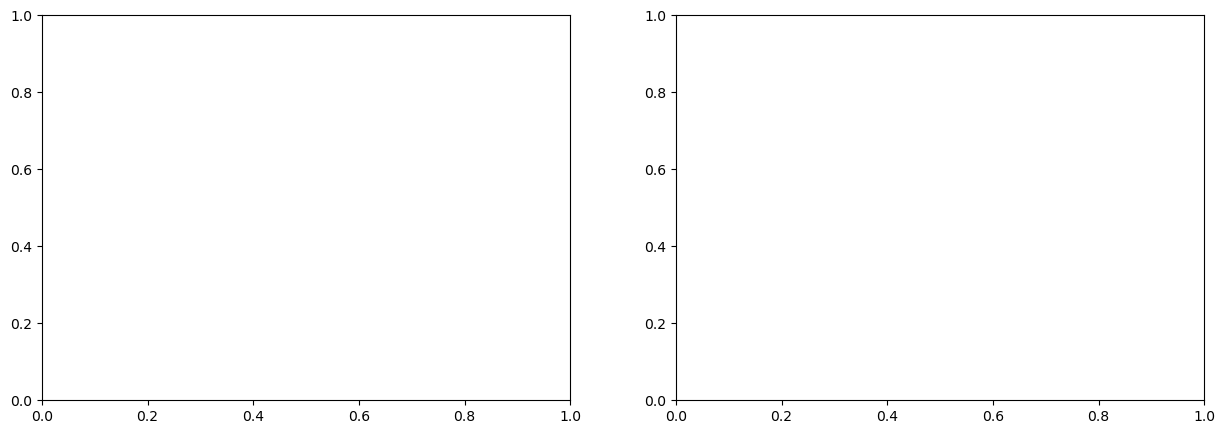

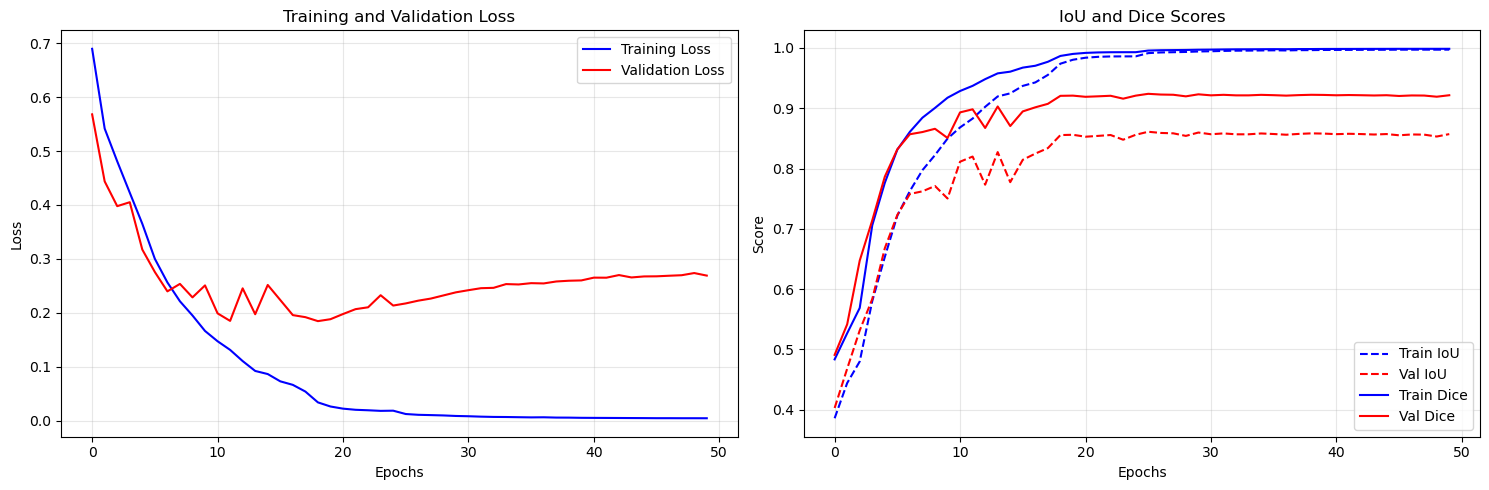

Training complete!


In [9]:
# Train U-Net model
print("Training U-Net...")
num_epochs = 50
cat_weight = 1
unet, history = train_unet(unet, train_loader, val_loader, num_epochs=num_epochs, cat_weight=cat_weight, device=device)
print("Training complete!")

## 7. Evaluate Model

In [10]:
# Evaluate model on validation set
print("\nEvaluating U-Net on validation set:")
val_results = evaluate_unet(unet, val_loader, device)


Evaluating U-Net on validation set:


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Class 'background': IoU=0.9522, Dice=0.9755
Class 'cat': IoU=0.7883, Dice=0.8816
Class 'dog': IoU=0.8307, Dice=0.9075
Pixel Accuracy: 0.9492
Mean IoU: 0.8571
Mean Dice: 0.9216



Visualizing U-Net results on validation set:


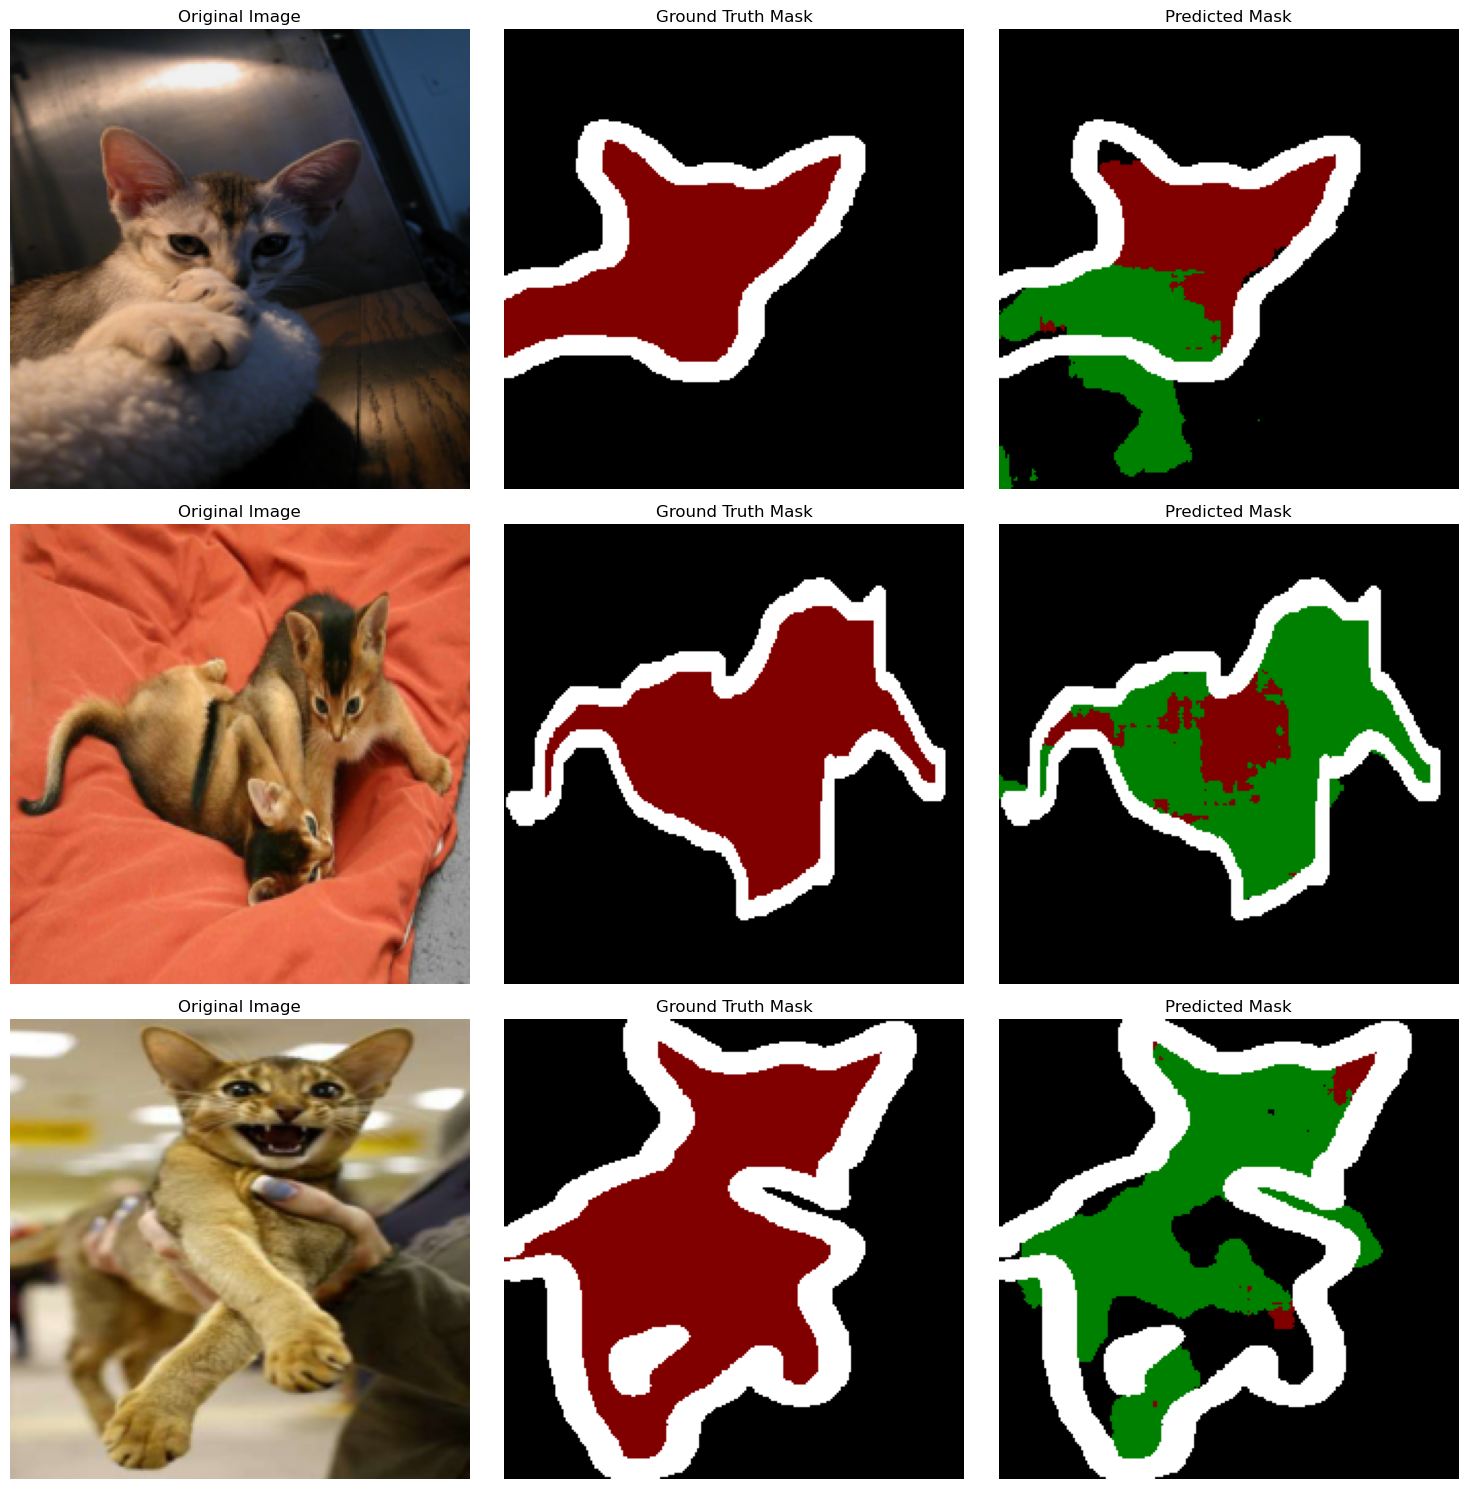

In [11]:
# Visualize results on validation set
print("\nVisualizing U-Net results on validation set:")
visualize_unet_results(unet, val_loader, device, num_samples=3)

In [12]:
# Evaluate model on test set
print("\nEvaluating U-Net on test set:")
test_results = evaluate_unet(unet, test_loader, device)


Evaluating U-Net on test set:


Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Class 'background': IoU=0.9537, Dice=0.9763
Class 'cat': IoU=0.7705, Dice=0.8704
Class 'dog': IoU=0.8380, Dice=0.9119
Pixel Accuracy: 0.9492
Mean IoU: 0.8541
Mean Dice: 0.9195



Visualizing U-Net results on test set:


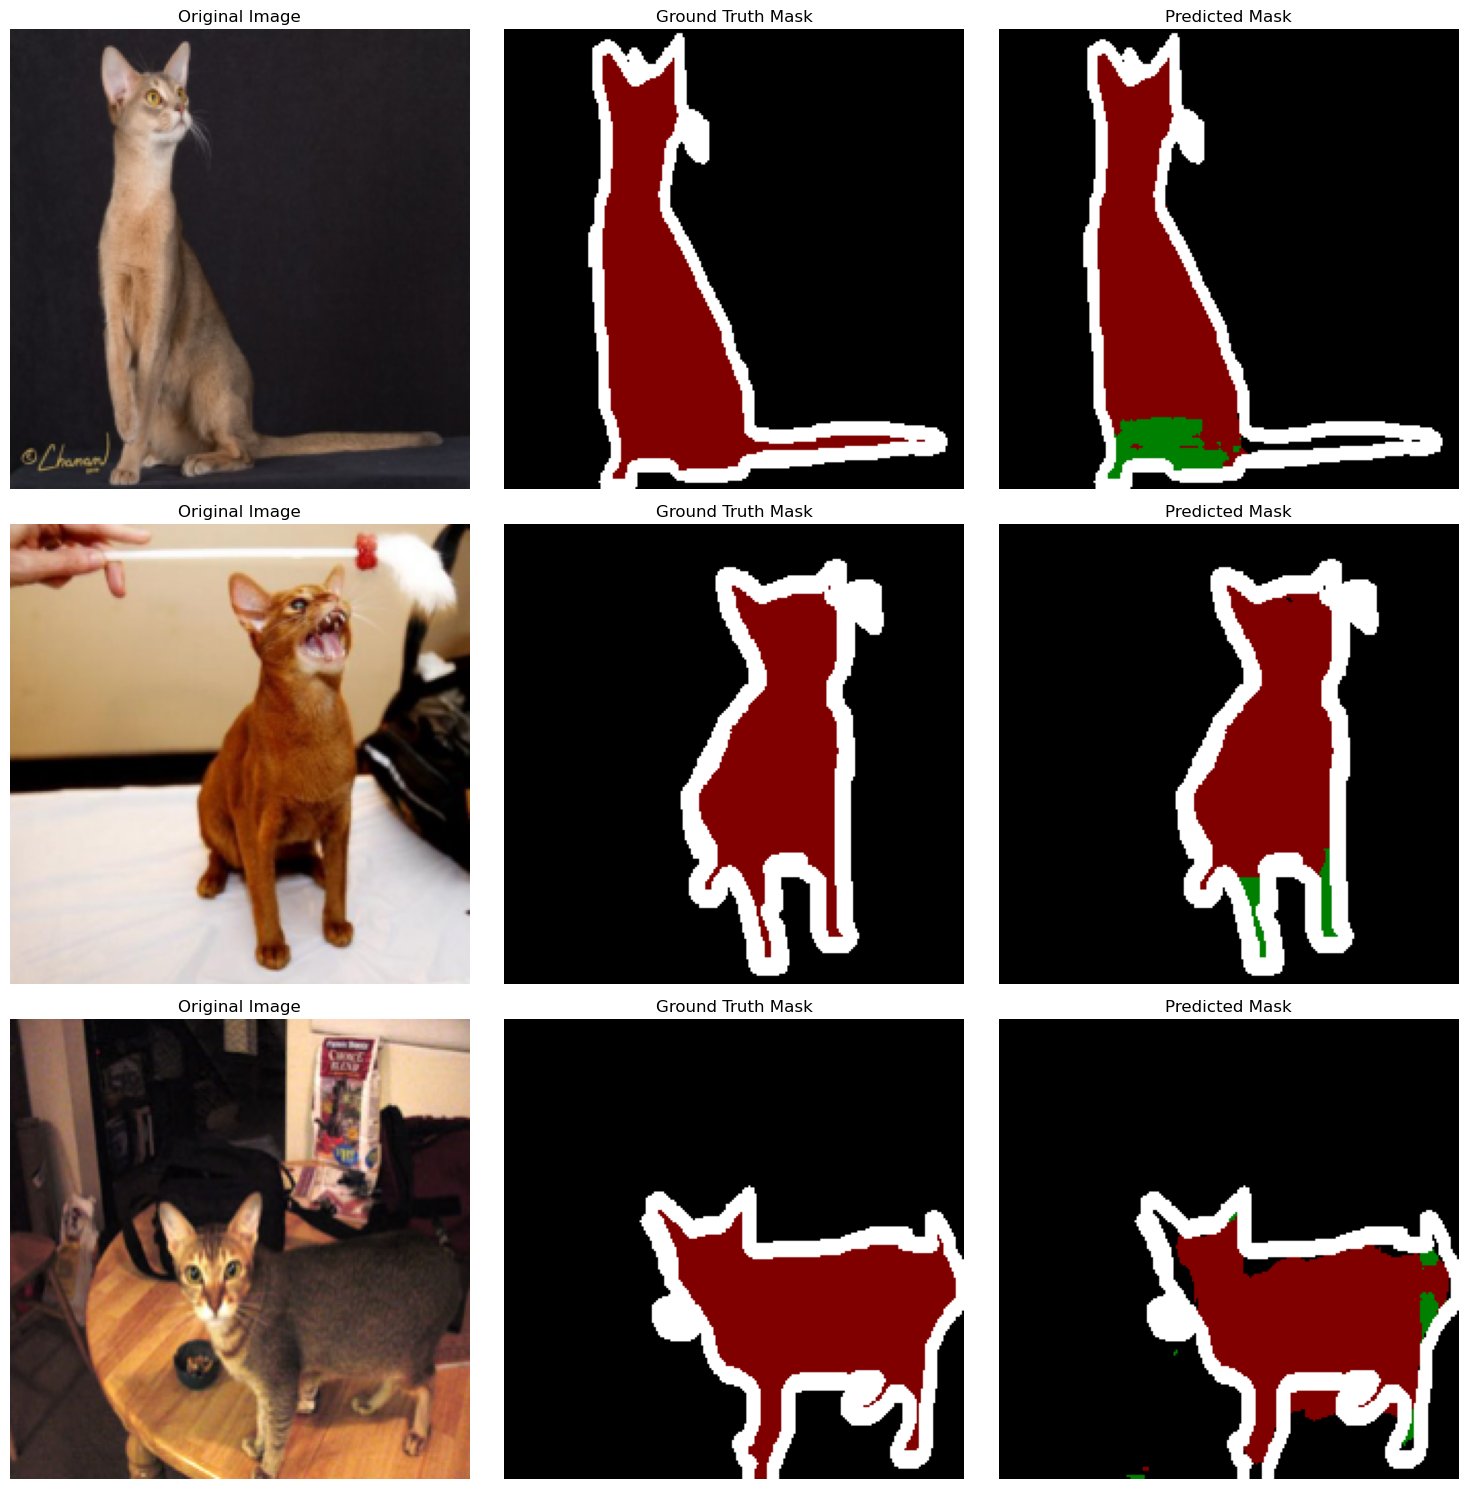

In [13]:
# Visualize results on test set
print("\nVisualizing U-Net results on test set:")
visualize_unet_results(unet, test_loader, device, num_samples=3)

## 8. Save Final Results and Model

In [14]:
# Display final results
print("\nFinal Results:")
print("Validation Set:")
print(f"  Pixel Accuracy: {val_results['pixel_accuracy']:.4f}")
print(f"  Mean IoU: {val_results['mean_iou']:.4f}")
print(f"  Mean Dice: {val_results['mean_dice']:.4f}")
print("Test Set:")
print(f"  Pixel Accuracy: {test_results['pixel_accuracy']:.4f}")
print(f"  Mean IoU: {test_results['mean_iou']:.4f}")
print(f"  Mean Dice: {test_results['mean_dice']:.4f}")

# Class-wise results
print("\nClass-wise Results:")
class_names = ["background", "cat", "dog"]
print("IoU:")
for cls in class_names:
    print(f"  {cls}: {test_results['class_ious'][cls]:.4f}")
print("Dice:")
for cls in class_names:
    print(f"  {cls}: {test_results['class_dice'][cls]:.4f}")


Final Results:
Validation Set:
  Pixel Accuracy: 0.9492
  Mean IoU: 0.8571
  Mean Dice: 0.9216
Test Set:
  Pixel Accuracy: 0.9492
  Mean IoU: 0.8541
  Mean Dice: 0.9195

Class-wise Results:
IoU:
  background: 0.9537
  cat: 0.7705
  dog: 0.8380
Dice:
  background: 0.9763
  cat: 0.8704
  dog: 0.9119


In [15]:
# Save the trained model one more time
torch.save(unet.state_dict(), 'unet_pet_segmentation_final.pth')
print("Model saved to unet_pet_segmentation_final.pth")

Model saved to unet_pet_segmentation_final.pth
